In [2]:
import re
import os
import csv
import numpy as np

from astropy.io import fits
import astropy.units as u
from astropy.coordinates import SkyCoord

import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Rectangle
import matplotlib.ticker as ticker
import matplotlib.gridspec as gridspec
from matplotlib.backends.backend_pdf import PdfPages
% matplotlib inline

import sys
if sys.platform=='darwin':
    top_path='/Users/codydirks/PGCC/'
else:
    top_path='/DataDisk/datafiles/PGCC_HST/'

x1d_dir=top_path+'x1d_files/'

c=300000.

def load_results(filename):
    gaia_filenames=[top_path+'gaia_data/TgasSource_000-000-0'+'{:02}'.format(i)+'.fits' for i in range(16)]
    pgcc_data=fits.open(top_path+'HFI_PCCS_GCC_R2.02.fits')[1].data
    sightline_pgcc_gaia_data=[]
    with open(filename,'r') as myfile:
        for line in myfile:
            dat=line.strip('|\n').split('|')
            sightline=dat[0]
            coords=dat[1].split(' ')
            ra=float(coords[0])*u.degree
            dec=float(coords[1])*u.degree
            pgcc=pgcc_data[int(dat[2])]
            if dat[3] != 'None':
                fl,idx=map(int,dat[3][1:-1].split(','))
                gaia_entry=fits.open(gaia_filenames[fl])[1].data[idx]
            else:
                gaia_entry=None
                
            sightline_pgcc_gaia_data.append([sightline,(ra,dec),pgcc,gaia_entry])
    return sightline_pgcc_gaia_data

# Returns the velocity shift necessary to convert Helio to LSR
# i.e. returns (V_lsr - V_helio)
def HelioToLSR(target_ra_deg, target_dec_deg):
    Vsun=19.7
    a0=271.0*np.pi/180.
    d0=30.0*np.pi/180.
    a=target_ra_deg*np.pi/180.
    d=target_dec_deg*np.pi/180.
    #shift=Vsun*(np.cos(a-a0)*np.cos(a0)*np.cos(a)+np.sin(d0)*np.sin(d))
    shift=Vsun*(np.cos(a0)*np.cos(d0)*np.cos(a)*np.cos(d)
                +np.sin(a0)*np.cos(d0)*np.sin(a)*np.cos(d)
                +np.sin(d0)*np.sin(d))
    return shift


def get_r_dist(pgcc,sightline_ra,sightline_dec):
    angle=pgcc['gau_position_angle']
    sin=np.sin(-angle)
    cos=np.cos(-angle)
    a=pgcc['gau_major_axis']/2.
    b=pgcc['gau_minor_axis']/2.
    gal=SkyCoord(ra=sightline_ra*u.degree,dec=sightline_dec*u.degree,frame='icrs').galactic
    del_l=60.*(gal.l.value-pgcc['glon'])
    del_b=60.*(gal.b.value-pgcc['glat'])
    return np.sqrt((((cos*del_l+sin*del_b)/a)**2+((sin*del_l-cos*del_b)/b)**2))


def get_cfa_vels_spec(data,hdr,glon,glat):
    cfa_vels=hdr['CRVAL1']+hdr['CDELT1']*np.arange(hdr['NAXIS1'])
    cfa_glons=hdr['CRVAL2']+hdr['CDELT2']*np.arange(hdr['NAXIS2'])
    cfa_glats=hdr['CRVAL3']+hdr['CDELT3']*np.arange(-hdr['NAXIS3']/2+1,hdr['NAXIS3']/2+1)
    
    if glon > 180:
        glon=glon-360
    glon_idx=min(range(len(cfa_glons)),key=lambda i: abs(cfa_glons[i]-glon))
    glat_idx=min(range(len(cfa_glats)),key=lambda i: abs(cfa_glats[i]-glat))
    cfa_spec=data[glat_idx,glon_idx,:]
    return cfa_vels,cfa_spec
    
    
def get_co_map(data,hdr,glon,glat,box,vel=0,vel_width=20):
    cfa_vels=hdr['CRVAL1']+hdr['CDELT1']*np.arange(hdr['NAXIS1'])
    cfa_glons=hdr['CRVAL2']+hdr['CDELT2']*np.arange(hdr['NAXIS2'])
    cfa_glats=hdr['CRVAL3']+hdr['CDELT3']*np.arange(-hdr['NAXIS3']/2+1,hdr['NAXIS3']/2+1)
    
    if glon > 180:
        glon=glon-360

    min_vel=vel-vel_width
    max_vel=vel+vel_width
    min_vel_idx=min(range(len(cfa_vels)), key=lambda i: abs(cfa_vels[i]-min_vel))
    max_vel_idx=min(range(len(cfa_vels)), key=lambda i: abs(cfa_vels[i]-max_vel))

    # Isolate a box around the sightline
    box=2.0
    glon_idx=min(range(len(cfa_glons)),key=lambda i: abs(cfa_glons[i]-glon))
    glat_idx=min(range(len(cfa_glats)),key=lambda i: abs(cfa_glats[i]-glat))
    min_glon=min(range(len(cfa_glons)),key=lambda i: abs(cfa_glons[i]-(glon+box/2.)))
    max_glon=min(range(len(cfa_glons)),key=lambda i: abs(cfa_glons[i]-(glon-box/2.)))
    min_glat=min(range(len(cfa_glats)),key=lambda i: abs(cfa_glats[i]-(glat-box/2.)))
    max_glat=min(range(len(cfa_glats)),key=lambda i: abs(cfa_glats[i]-(glat+box/2.)))
    #print cfa_data[min_vel_idx:max_vel_idx,min_glon:max_glon,min_glat:max_glat]
    cube=data[min_glat:max_glat,min_glon:max_glon,min_vel_idx:max_vel_idx]
    cube[np.isnan(cube)]=0
    dat=np.sum(cube,axis=2)
    #if cfa_glons[min_glon] < 0:
    #    return dat[::-1,:],[cfa_glons[min_glon]+360,cfa_glons[max_glon]+360,cfa_glats[min_glat],cfa_glats[max_glat]]
    #else:
    #return dat[::-1,:],[cfa_glons[min_glon],cfa_glons[max_glon],cfa_glats[min_glat],cfa_glats[max_glat]]
    return dat[::-1,:],[1.1,-1.1,-1.1,1.1]

In [3]:
with open('primary_sightlines.csv','rb') as csvfile:
    inp=csv.reader(csvfile)
    primary_sightlines=inp.next()
    
with open('secondary_sightlines.csv','rb') as csvfile:
    inp=csv.reader(csvfile)
    secondary_sightlines=inp.next()
    
with open('in_front_sightlines.csv','rb') as csvfile:
    inp=csv.reader(csvfile)
    in_front_sightlines=inp.next()

In [4]:
filename='sightline_pgcc_gaia_results.txt'
all_data=load_results(filename)
all_data.sort(key=lambda x: (x[0][0],int(re.search(r'\d+',x[0]).group())))
print len(all_data)

primary_sample=[x for x in all_data if x[0] in primary_sightlines]
secondary_sample=[x for x in all_data if x[0] in secondary_sightlines]
in_front_sample=[x for x in all_data if x[0] in in_front_sightlines]
ambiguous_sample=[x for x in all_data if (x[0] not in primary_sightlines+secondary_sightlines+in_front_sightlines)]
print len(primary_sample),len(secondary_sample),len(in_front_sample),len(ambiguous_sample)

93
20 42 10 21


In [5]:
cfa_path=top_path+'CO/Columbia-CfA/COGAL_all_raw.fits'
hdulist=fits.open(cfa_path)
cfa_data=hdulist[0].data
cfa_hdr=hdulist[0].header

pgcc_data=fits.open(top_path+'HFI_PCCS_GCC_R2.02.fits')[1].data

In [20]:
cl_line=1347.2396
o_line=1355.5977
co_lines=[1544.448,1509.748,1477.565,1447.352,1419.044,1392.525,1367.623,1344.186,1322.15,1301.403,1281.866,1263.433,1246.059]
majorLocator=ticker.MultipleLocator(0.5)
for pdffile,var in [(  'primary_sightlines.pdf',  primary_sample),
                    ('secondary_sightlines.pdf',secondary_sample),
                    ('ambiguous_sightlines.pdf',ambiguous_sample),
                    ( 'in_front_sightlines.pdf', in_front_sample),
                    (      'all_sightlines.pdf',       all_data)]:
            
    pdf=PdfPages(pdffile)
    for sl in var:
        fig=plt.figure(1,figsize=(12,9))
        G=gridspec.GridSpec(5,2,hspace=0)
        cl_subplt,o_subplt,co_subplt,star_subplt,pgcc_subplt=[plt.subplot(G[i,1]) for i in range(0,5)]
        subplts=(o_subplt,cl_subplt,co_subplt,star_subplt,pgcc_subplt)
        [x.set_ylim(-0.1,1.2) for x in subplts[0:3]]
        [x.set_xlim(-105,105) for x in subplts]
        [x.set_xticks([]) for x in subplts[0:4]]
        #[[x.axvline(y,0,1,ls='--',color='k') for y in np.arange(-200,200,25)]for x in subplts]
        pgcc_subplt.set_xlabel('LSR Velocity (km/s)',fontsize=20)

        fig.text(0.3,0.87,sl[0],fontsize=25,ha='right',va='top')
        #fig.text(0.05,0.5,'Intensity',fontsize=20,rotation=90)

        heliotolsr=HelioToLSR(sl[1][0].value,sl[1][1].value)
        cl_spec=[x for x in os.listdir(x1d_dir+sl[0]+'/E140H') if x.endswith('_'+str(cl_line)+'.dat')]
        o_spec=[x for x in os.listdir(x1d_dir+sl[0]+'/E140H') if x.endswith('_'+str(o_line)+'.dat')]
        if len(cl_spec)>0 and len(o_spec)>0:
            cl_wav=[]
            cl_flx=[]
            o_wav=[]
            o_flx=[]
            for line in open(x1d_dir+sl[0]+'/E140H/'+cl_spec[0]):
                wav,flx=line.strip('\n').split()
                cl_wav.append(float(wav))
                cl_flx.append(float(flx))
            for line in open(x1d_dir+sl[0]+'/E140H/'+o_spec[0]):
                wav,flx=line.strip('\n').split()
                o_wav.append(float(wav))
                o_flx.append(float(flx))
            cl_wav=np.array(cl_wav)
            cl_vel=(c*(cl_wav-cl_line)/cl_line)+heliotolsr
            cl_flx=np.array(cl_flx)
            cl_flx=cl_flx[abs(cl_vel)<100]
            cl_vel=cl_vel[abs(cl_vel)<100]
            cl_subplt.plot(cl_vel,cl_flx, 'k-')

            o_wav=np.array(o_wav)
            o_vel=(c*(o_wav-o_line)/o_line)+heliotolsr
            o_flx=np.array(o_flx)
            o_flx=o_flx[abs(o_vel)<100]
            o_vel=o_vel[abs(o_vel)<100]
            o_subplt.plot(o_vel,o_flx, 'k-')

        for co in co_lines:
            co_spec=[x for x in os.listdir(x1d_dir+sl[0]+'/E140H') if x.endswith('_'+str(co)+'.dat')]
            if len(co_spec)>0:
                co_wav=[]
                co_flx=[]
                for line in open(x1d_dir+sl[0]+'/E140H/'+co_spec[0]):
                    wav,flx=line.strip('\n').split()
                    co_wav.append(float(wav))
                    co_flx.append(float(flx))
                co_wav=np.array(co_wav)
                co_vel=(c*(co_wav-co)/co)+heliotolsr
                co_flx=np.array(co_flx)
                co_flx=co_flx[abs(co_vel)<100]
                co_vel=co_vel[abs(co_vel)<100]
                co_line=co
                co_subplt.plot(co_vel,co_flx, 'k-')
                break


        cl_subplt.text(1.01,0.5,'Cl I', transform=cl_subplt.transAxes,fontsize=20,ha='left',va='center')
        o_subplt.text(1.01,0.5,'O I', transform=o_subplt.transAxes,fontsize=20,ha='left',va='center')
        co_subplt.text(1.01,0.5,'CO\n'+str(co_line).split('.')[0]+'\nAbs', transform=co_subplt.transAxes,fontsize=20,ha='left',va='center')


        starcoords=SkyCoord(ra=sl[1][0],dec=sl[1][1],frame='icrs').galactic
        cfa_vels,star_cfa_spec=get_cfa_vels_spec(cfa_data,cfa_hdr,starcoords.l.value,starcoords.b.value)
        star_cfa_spec[np.isnan(star_cfa_spec)]=0.

        cfa_vels,pgcc_cfa_spec=get_cfa_vels_spec(cfa_data,cfa_hdr,sl[2]['glon'],sl[2]['glat'])
        pgcc_cfa_spec[np.isnan(pgcc_cfa_spec)]=0.

        star_subplt.plot(cfa_vels,star_cfa_spec, 'k-')
        star_subplt.text(1.01,0.5,'CO\n(CfA)\nStar', transform=star_subplt.transAxes,fontsize=20,ha='left',va='center')

        pgcc_subplt.plot(cfa_vels,pgcc_cfa_spec, 'k-')
        pgcc_subplt.text(1.01,0.5,'CO\n(CfA)\nPGCC', transform=pgcc_subplt.transAxes,fontsize=20,ha='left',va='center')

        if sl[0] not in ('HD37367','HD106943','HD138679','HD52329','HD108002') and (min(co_flx) < np.mean(co_flx[co_flx>0.8])-5.*np.std(co_flx[co_flx>0.8])):
            min_vel=co_vel[np.argmin(co_flx)]
        elif sl[0] not in ('HD108610','HD52329') and min(o_flx) < np.mean(o_flx[o_flx>0.8])-5.*np.std(o_flx[o_flx>0.8]):
            min_vel=o_vel[np.argmin(o_flx)]
        elif sl[0] not in ('HD52329') and min(cl_flx) < np.mean(cl_flx[cl_flx>0.8])-5.*np.std(cl_flx[cl_flx>0.8]):
            min_vel=cl_vel[np.argmin(cl_flx)]
        elif sl[0] not in ('HD52329') and max(star_cfa_spec[star_cfa_spec>-100]) > np.mean(star_cfa_spec[star_cfa_spec<0.5])+5*np.std(star_cfa_spec[star_cfa_spec<0.5]):
            min_vel=cfa_vels[np.argmax(star_cfa_spec)]
        elif max(pgcc_cfa_spec) > np.mean(pgcc_cfa_spec[pgcc_cfa_spec<0.5])+5*np.std(pgcc_cfa_spec[pgcc_cfa_spec<0.5]):
            min_vel=cfa_vels[np.argmax(pgcc_cfa_spec)]
        else:
            min_vel=0
        vel_width=5.
        #[x.axvline(min_vel,0,1,ls='-',color='r',lw=1) for x in subplts]
        [[x.axvline(y,0,1,ls='--',color='r',lw=1) for y in (min_vel-vel_width,min_vel+vel_width)] for x in subplts]

        inst=plt.subplot(G[2:,0])
        dat,extents=get_co_map(cfa_data,cfa_hdr,sl[2]['glon'],sl[2]['glat'],2.0,min_vel,vel_width)
        cax=inst.imshow(dat, extent=extents,cmap='viridis')
        inst.plot(starcoords.l.value-sl[2]['glon'],starcoords.b.value-sl[2]['glat'],'ro',ms=5)
        inst.xaxis.set_major_locator(majorLocator)
        inst.yaxis.set_major_locator(majorLocator)
        inst.set_xticklabels([round(sl[2][1]+item,2) for item in inst.get_xticks()])
        inst.set_yticklabels([round(sl[2][2]+item,2) for item in inst.get_yticks()])
        inst.set_xlabel('Galactic Longitude')
        inst.set_ylabel('Galactic Latitude')
        for i in range(1,4):
            ell=Ellipse(xy=(0,0),width=i*sl[2]['gau_major_axis']/60.,
                        height=i*sl[2]['gau_minor_axis']/60.,angle=-(180./np.pi)*sl[2]['gau_position_angle'])
            ell.set_facecolor('w')
            ell.set_alpha(0.8/i)
            inst.add_patch(ell)

        for pgcc in pgcc_data:
            pgcc_glon=pgcc[1]
            pgcc_glat=pgcc[2]
            if pgcc[0] != sl[2][0] and abs(pgcc_glon-sl[2][1])<1. and abs(pgcc_glat-sl[2][2])<1.:
                for i in range(1,4):
                    ell=Ellipse(xy=(pgcc_glon-sl[2][1],pgcc_glat-sl[2][2]),width=i*pgcc['gau_major_axis']/60.,
                                height=i*pgcc['gau_minor_axis']/60.,angle=-(180./np.pi)*pgcc['gau_position_angle'])
                    ell.set_facecolor('w')
                    ell.set_alpha(0.4/i)
                    inst.add_patch(ell)


        gaia_subplt=plt.subplot(G[1,0])
        gaia_subplt.set_ylim(0,1)
        gaia_subplt.set_yticklabels([])
        gaia_subplt.yaxis.set_major_locator(plt.NullLocator())
        gaia_subplt.xaxis.tick_top()
        gaia_subplt.set_xlim(50,10000)
        gaia_subplt.set_title('Distance (pc)',fontsize=10,y=1.2)
        gaia_subplt.set_xscale('log')
        gaia_dat=sl[3]
        pgcc_dat=sl[2]
        pgcc_dist=1000.*pgcc_dat['dist']
        pgcc_min_dist=pgcc_dist-1000.*pgcc_dat['dist_sig']
        pgcc_max_dist=pgcc_dist+1000.*pgcc_dat['dist_sig']
        gaia_subplt.errorbar(pgcc_dist,0.6,xerr=[[pgcc_dist-pgcc_min_dist],[pgcc_max_dist-pgcc_dist]],fmt='o',color='k',ms=10)
        if gaia_dat != None:
            plx=gaia_dat['parallax']
            plx_err=gaia_dat['parallax_error']
            star_dist=1000./plx
            star_min_dist=1000./(plx+plx_err)
            star_max_dist=1000./(plx-plx_err)
            if star_max_dist<0:
                star_max_dist = 10000.
            gaia_subplt.errorbar(star_dist,0.4,xerr=[[star_dist-star_min_dist],[star_max_dist-star_dist]],fmt='*',color='k',ms=15)

        if (len(star_cfa_spec[~np.isnan(star_cfa_spec)]) > 0 or len(pgcc_cfa_spec[~np.isnan(pgcc_cfa_spec)]) > 0):
            if len(star_cfa_spec[~np.isnan(star_cfa_spec)]) > 0 and max(star_cfa_spec[~np.isnan(star_cfa_spec)])<1:
                star_subplt.set_ylim(-0.8,3.2)
            if len(pgcc_cfa_spec[~np.isnan(pgcc_cfa_spec)]) > 0 and max(pgcc_cfa_spec[~np.isnan(pgcc_cfa_spec)])<1:
                pgcc_subplt.set_ylim(-0.8,3.2)
            pdf.savefig()
        plt.cla()
        plt.close()
    pdf.close()


/home/cody/python/lib/python2.7/site-packages/ipykernel/__main__.py:72: RuntimeWarning: divide by zero encountered in double_scalars


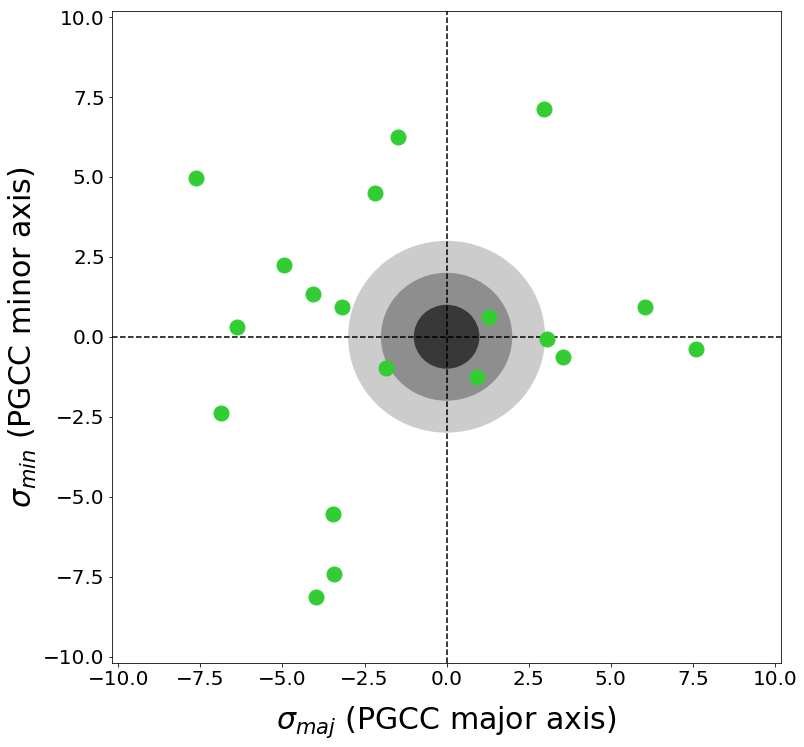

In [11]:
fig=plt.figure(1,figsize=(12,12))
subplt=plt.subplot(111)

subplt.set_xlim(-10.2,10.2)
subplt.set_ylim(-10.2,10.2)
subplt.set_xlabel('$\sigma_{maj}$ (PGCC major axis)',fontsize=30,labelpad=15)
subplt.set_ylabel('$\sigma_{min}$ (PGCC minor axis)',fontsize=30)
subplt.tick_params(axis='x',labelsize=20)
subplt.tick_params(axis='y',labelsize=20)
for i in range(1,4):
    ell=Ellipse(xy=(0,0),width=2*i,
                height=2*i
                ,angle=0)
    ell.set_facecolor('k')
    ell.set_alpha(0.6/i)
    subplt.add_patch(ell)
        
for entry in primary_sample:
    sightline=entry[0]
    ra,dec=entry[1]
    pgcc=entry[2]
    r_dist=get_r_dist(pgcc,ra.value,dec.value)

    galcoord=SkyCoord(ra=ra,dec=dec).galactic
    del_l=60.*(galcoord.l.value-pgcc['glon'])
    del_b=60.*(galcoord.b.value-pgcc['glat'])
    theta=np.arctan(del_b/del_l)
    omega=-pgcc['gau_position_angle']
    phi=theta-omega
    sig_x=r_dist*np.cos(phi)
    sig_y=r_dist*np.sin(phi)
    if del_l<0:
        sig_x=-sig_x
        sig_y=-sig_y
    zorder=1
    if entry[0] in primary_sightlines:
        col='limegreen'
        zorder=2
    elif entry[0] in secondary_sightlines:
        col='b'
    elif entry[0] in in_front_sightlines:
        col='r'
    else:
        col='k'
    
    subplt.plot(sig_x,sig_y,marker='o',color=col,ms=15,mec=col,zorder=zorder)
    #subplt.text(sig_x,sig_y,sightline)

subplt.axvline(0,0,1,color='k',ls='--',zorder=0)
subplt.axhline(0,0,1,color='k',ls='--',zorder=0)

In [10]:
c_lines=[1328.833, 1280.1353]

for sample in (primary_sample, secondary_sample,in_front_sample,ambiguous_sample):
    for sl in sample:
        print sl[0],
        #for c in c_lines:
            #c_spec=[x for x in os.listdir(x1d_dir+sl[0]+'/E140H') if x.endswith('_'+str(c)+'.dat')]
        co_res=[x for x in os.listdir(x1d_dir+sl[0]+'/E140H') if x.startswith('co_') and x.endswith('.txt')]
            #if len(c_spec)>0:
        print co_res
        print
    print
    print


HD13841 ['co_1344_results.txt']

HD23180 ['co_1509_results.txt']

HD23478 ['co_1344_results.txt']

HD24398 ['co_1509_results.txt']

HD24534 ['co_1544_results.txt']

HD25443 ['co_1344_results.txt']

HD43582 ['co_1392_results.txt']

HD72350 ['co_1344_results.txt']

HD108927 ['co_1344_results.txt']

HD112999 ['co_1344_results.txt']

HD124314 ['co_1544_results.txt']

HD147683 ['co_1544_results.txt']

HD148594 ['co_1344_results.txt']

HD148937 ['co_1544_results.txt']

HD165918 ['co_1447_results.txt']

HD185418 ['co_1344_results.txt']

HD208947 ['co_1344_results.txt']

HD210839 ['co_1344_results.txt']

HD232522 ['co_1509_results.txt']

HD254755 ['co_1392_results.txt']



CPD-592603 ['co_1544_results.txt']

HD1383 []

HD14818 []

HD15137 []

HD37061 []

HD37367 []

HD37903 []

HD40893 []

HD52266 []

HD62542 ['co_1419_results.txt']

HD69106 []

HD72754 []

HD75309 []

HD93205 []

HD93222 ['co_1544_results.txt']

HD99857 []

HD106343 []

HD108002 []

HD108639 []

HD110434 []

HD111934 []

HD11

HD13841 2.2851e+14 2.8255e+13
HD23180 3.0681e+14 2.8904e+13
HD23478 9.6189e+14 9.1087e+13
HD24398 1.3902e+15 4.7679e+13
HD24534 2.0036e+16 1.59e+15
HD25443 6.4411e+14 6.8277e+13
HD43582 9.6305e+13 3.5301e+13
HD72350 1.2721e+14 1.6209e+13
HD108927 8.9731e+14 3.8363e+13
HD112999 7.6325e+12 7.4134e+12
HD124314 1.3763e+14 2.3458e+13
HD147683 7.7572e+14 5.8341e+13
HD148594 8.2404e+12 7.7523e+12
HD148937 1.9205e+14 1.3449e+13
HD165918 2.2797e+13 2.0546e+12
HD185418 3.7703e+14 1.9621e+13


/home/cody/python/lib/python2.7/site-packages/ipykernel/__main__.py:72: RuntimeWarning: divide by zero encountered in double_scalars


HD208947 1.2299e+14 1.1493e+13
HD210839 1.2261e+15 3.9778e+13
HD232522 5.1242e+13 3.2602e+12
HD254755 5.3977e+14 7.9571e+13


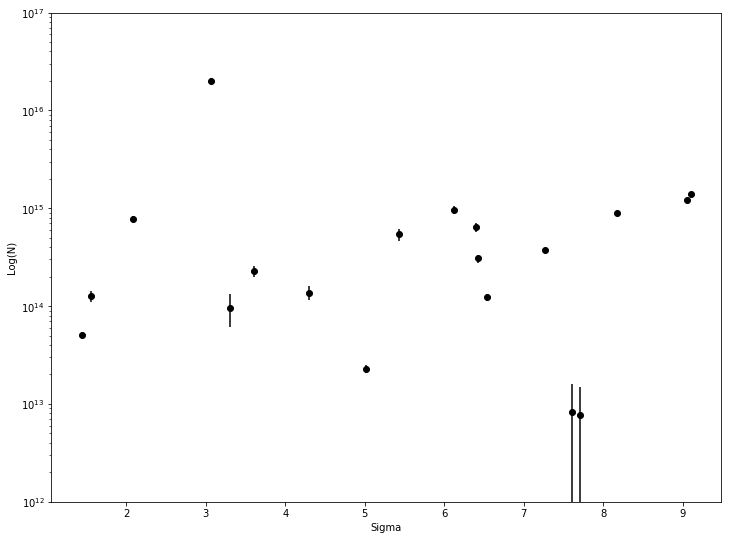

In [37]:
fig=plt.figure(figsize=(12,9))
subplt1=plt.subplot(111)
subplt1.set_ylim(float(1e12),float(1e17))
#subplt1.set_xlim(0,10)
subplt1.set_xlabel('Sigma')
subplt1.set_ylabel('Log(N)')
subplt1.set_yscale('log')
for entry in primary_sample:
    sightline=entry[0]
    ra,dec=entry[1]
    pgcc=entry[2]
    r_dist=get_r_dist(pgcc,ra.value,dec.value)
    co_res=[x for x in os.listdir(x1d_dir+entry[0]+'/E140H') if x.startswith('co_') and x.endswith('.txt')][0]
    with open(x1d_dir+entry[0]+'/E140H/'+co_res, 'r') as myfile:
        line=[x.strip() for x in myfile.readlines()][-1]
    n=float(line.split('error')[0].split('=')[1].strip())
    err=float(line.split('=')[-1].strip())
    print entry[0],n,err
    subplt1.errorbar(r_dist,n,yerr=err,marker='o',color='k')